In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym


env = gym.make("CartPole-v0")
print("Setup complete")


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Setup complete


(4, 4)
0
1
2
3
4
5
6
7
8
9
10
0
1
2
NUM RESETS: 31
Average Reward per epoch: 32.12903225806452
range(0, 10000)
(10000, 4)
Phi


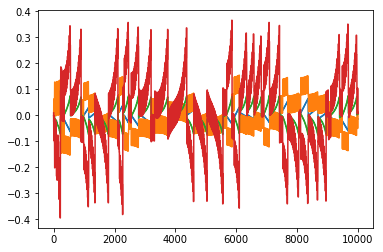

Pred phi


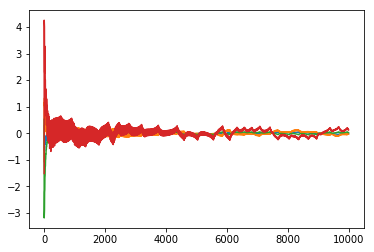

ds


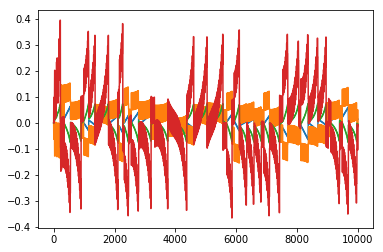

A1


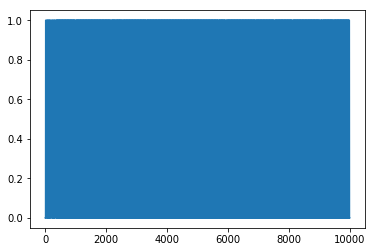

A2


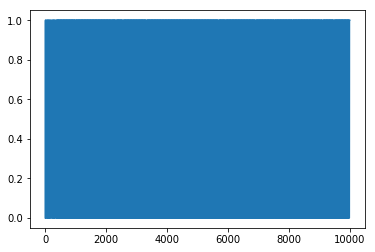

diffs


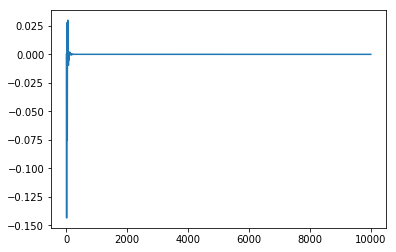

ez1


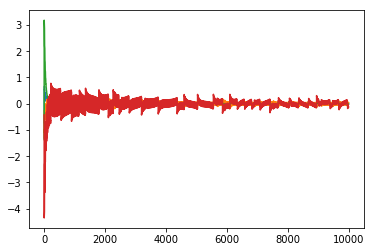

ez2


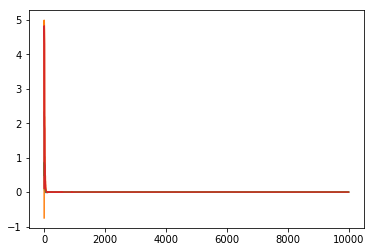

ez3


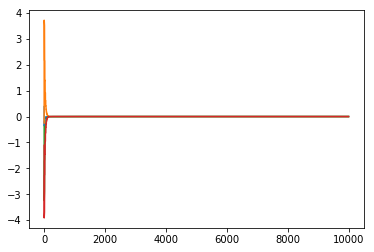

mu1


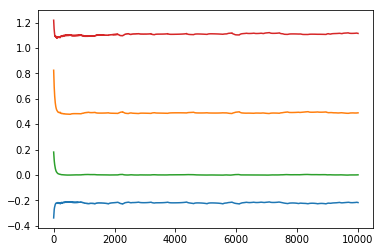

mu2


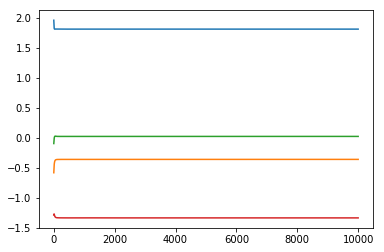

mu3


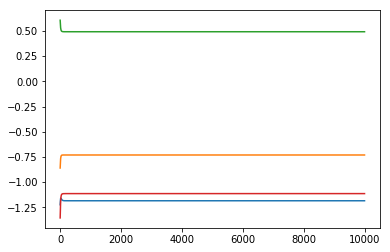

w0


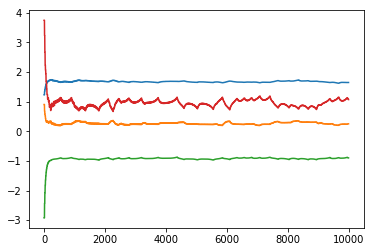

w1


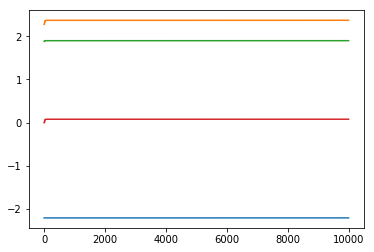

w2


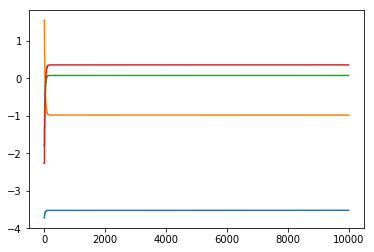

wa1


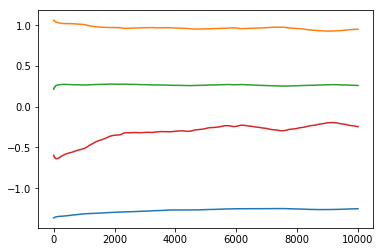

wa2


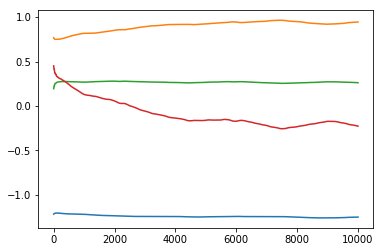

mu1grads


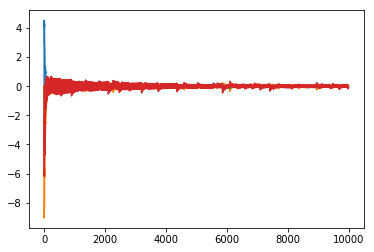

diffs1


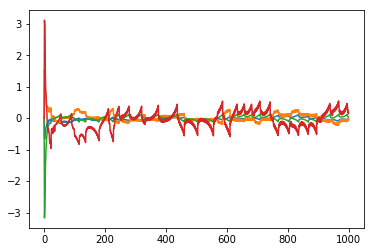

diffs2


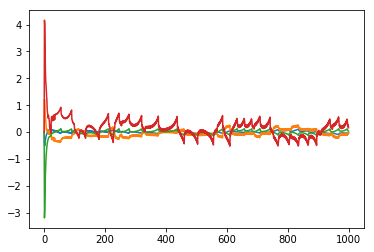

In [201]:
epochs = 1000
inf_num = 10

def reshapes(l, val):
    for i, e in enumerate(l):
        print(i)
        l[i] = np.reshape(np.array(e), (len(e), val))
    return l

def reshape_sum_weights(l):
    for i, e in enumerate(l):
        l[i] = np.array(np.sum(e, axis=2))
    return l

def sum_of_squares(l):
    tot = 0
    for e in l:
        tot += np.sum(np.square(e))
    return tot

d1 = 4
d2 = 4

phi = [np.reshape(np.array(env.reset()), (4,1))]
mu1 = [np.random.normal(size=[d1,1])]
mu2 = [np.random.normal(size=[d2,1])]
mu3 = [np.random.normal(size=[d2,1])]
prevObs = phi[0]

ez1 = [np.random.normal(size=[4,1])]
ez2 = [np.random.normal(size=[d1,1])]
ez3 = [np.random.normal(size=[d2,1])]


p1 = 0.1
p2 = 0.1
p3 = 0.1

w0 = [np.random.normal(size=[4,d1])]
w1 = [np.random.normal(size=[d1,d2])]
w2 = [np.random.normal(size=[d2,d2])]



print(w0[0].shape)

wa1 = [np.random.normal(size=[4,1])]
wa2 = [np.random.normal(size=[4,1])]

a1 = [0]
a2 = [0]
rewards = []
rewards_per_epoch = []
actions = []
diffs1 = [np.reshape(np.array([0,0,0,0]), (4,1))]
diffs2 = [np.reshape(np.array([0,0,0,0]), (4,1))]

prior = np.reshape(np.array([0,0,0,0]), (4,1))
num_resets = 0
diffs =[0]
preds = [np.random.normal(size=[4,1])]
learning_rate = 0.001
ds = [prior]
mu1grads = [np.reshape(np.array([0,0,0,0]), (4,1))]

for i in range(1,epochs * inf_num):
    if i % inf_num == 0 or i == 1:
        pred = np.dot(w0[i-1], mu1[i-1])
        diffa01 = prior - (pred + wa1[i-1]) 
        diffa11 = prior - (pred + wa2[i-1])
        #diff = np.sum(np.abs(diffa01)) - np.sum(np.abs(diffa11))
        #print(diff)
        diff = np.square(diffa01[2]) - np.square(diffa11[2])
        if diff >=0:
            # a1 is best
            action = 0
            a1.append(1)
            a2.append(0)
        else:
            action = 1
            a1.append(0)
            a2.append(1)
       
        o, r, done, info = env.step(action)
        rewards.append(r)
        env.render()
        o = np.reshape(np.array(o), (4,1)) / 3.
        phi.append(o)
        prevObs = o
        diffs.append(diff)
        diffs1.append(o - diffa01)
        diffs2.append(o - diffa11)

        
        if done:
            #prior = np.reshape(np.array(env.reset()), (4,1))
            #print(o)
            env.reset()
            prior = np.reshape(np.array([0,0,0,0]), (4,1))
            num_resets +=1
            rewards_per_epoch.append(np.sum(rewards))
            rewards = []
    else:
        #print(phi[i-1])
        phi.append(phi[i-1])
        a1.append(a1[i-1])
        a2.append(a2[i-1])
        diffs.append(diffs[i-1])
        
    ez1.append(phi[i] - (np.dot(w0[i-1], mu1[i-1]) + (wa1[i-1] * a1[i]) + (wa2[i-1] * a2[i])))
    ez2.append(mu1[i-1] - np.dot(w1[i-1], mu2[i-1]))
    ez3.append(mu2[i-1] - np.dot(w2[i-1], mu3[i-1]))
    
    mu1grad = np.dot(w0[i-1].T, ez1[i]) + ez2[i]
    mu2grad = np.dot(w1[i-1].T, ez2[i]) + ez3[i]
    mu3grad = np.dot(w2[i-1].T, ez3[i])
    mu1grads.append(mu1grad)
    
    mu1.append(mu1[i-1] + (learning_rate * mu1grad))
    mu2.append(mu2[i-1] + (learning_rate * mu2grad))
    mu3.append(mu3[i-1] + (learning_rate * mu3grad))
    
    d = prior - o
    ds.append(d)
    pred = np.dot(w0[i-1], mu1[i-1])
    diffa01 = prior - (pred + wa1[i-1]) 
    diffa02 = prior - (pred + wa2[i-1])
    wa1.append(wa1[i-1] + (learning_rate * ((ez1[i] * a1[i]) + (d * a1[i]))))
    wa2.append(wa2[i-1] + (learning_rate * ((ez1[i] * a2[i]) + (d * a2[i]))))
    
    if i % inf_num == 0:
        w0.append(w0[i-1] + (100*learning_rate * np.dot(ez1[i], mu1[i].T))) 
        w1.append(w1[i-1] + (100*learning_rate * np.dot(ez2[i], mu2[i].T)))
        w2.append(w2[i-1] + (100* learning_rate * np.dot(ez3[i], mu3[i].T)))
        
    else:
        w0.append(w0[i-1])
        w1.append(w1[i-1])
        w2.append(w2[i-1])
        
        
    preds.append(np.dot(w0[i-1], mu1[i-1]) + (wa1[i-1] * a1[i]) + (wa2[i-1] * a2[i]))
    
    
phi, ez1, ez2, mu1, wa1, wa2, preds,ds,mu1grads, diffs1, diffs2 = reshapes([phi, ez1, ez2, mu1,wa1, wa2, preds,ds, mu1grads, diffs1, diffs2],d1)
ez3, mu2, mu3 = reshapes([ez3,mu2,mu3], d2)
w0, w1, w2 = reshape_sum_weights([w0, w1, w2])

print("NUM RESETS: " + str(num_resets))
print("Average Reward per epoch: " + str(np.mean(rewards_per_epoch)))
n  = range(epochs * inf_num )
print(n)
print(phi.shape)
print("Phi")
plt.plot(n, phi)
plt.show()
print("Pred phi")
plt.plot(n, preds)
plt.show()
print("ds")
plt.plot(n, ds)
plt.show()
print("A1")
plt.plot(n, a1)
plt.show()
print("A2")
plt.plot(n, a2)
plt.show()
print("diffs")
plt.plot(n, diffs)
plt.show()
print("ez1")
plt.plot(n, ez1)
plt.show()
print("ez2")
plt.plot(n, ez2)
plt.show()
print("ez3")
plt.plot(n, ez3)
plt.show()
print("mu1")
plt.plot(n, mu1)
plt.show()
print("mu2")
plt.plot(n, mu2)
plt.show()
print("mu3")
plt.plot(n, mu3)
plt.show()
print("w0")
plt.plot(n, w0)
plt.show()
print("w1")
plt.plot(n, w1)
plt.show()
print("w2")
plt.plot(n, w2)
plt.show()
print("wa1")
plt.plot(n, wa1)
plt.show()
print("wa2")
plt.plot(n, wa2)
plt.show()
print("mu1grads")
plt.plot(n, mu1grads)
plt.show()
print("diffs1")
#
plt.plot(diffs1)
plt.show()
print("diffs2")
plt.plot(diffs2)
plt.show()

(4, 4)
[[-0.06452557]
 [-0.70531074]
 [ 0.08894896]
 [ 1.10076731]]
[[-0.04772578]
 [-0.57750231]
 [ 0.08229924]
 [ 0.96056721]]
[[-0.03633185]
 [-0.52487232]
 [ 0.07277711]
 [ 0.84415352]]
[[-0.06071938]
 [-0.59898096]
 [ 0.07457908]
 [ 0.93812706]]
[[-0.05999216]
 [-0.58477273]
 [ 0.08666363]
 [ 0.97046606]]
[[-0.06029437]
 [-0.60135991]
 [ 0.0767718 ]
 [ 0.93564452]]
[[-0.02308546]
 [-0.52524724]
 [ 0.07365652]
 [ 0.84900471]]
[[-0.07111018]
 [-0.6562414 ]
 [ 0.0849801 ]
 [ 1.02659167]]
[[-0.05050645]
 [-0.57664326]
 [ 0.07585348]
 [ 0.93666431]]
[[-0.04669011]
 [-0.21289889]
 [ 0.07181038]
 [ 0.39401782]]
[[-0.04386921]
 [-0.14745336]
 [ 0.07067024]
 [ 0.33585938]]
[[-0.04720399]
 [-0.21075438]
 [ 0.07116301]
 [ 0.40216834]]
[[-0.06920667]
 [-0.14595416]
 [ 0.0769724 ]
 [ 0.34602304]]
[[-0.05755805]
 [-0.14620685]
 [ 0.06983911]
 [ 0.33050257]]
[[-0.04649613]
 [-0.27230399]
 [ 0.07362134]
 [ 0.49347381]]
[[-0.03540467]
 [-0.15087681]
 [ 0.07108381]
 [ 0.34711801]]
[[-0.06381886]
 [

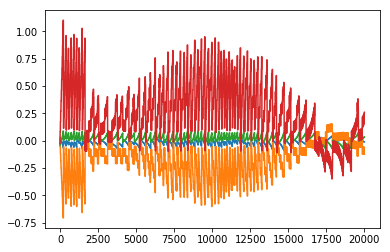

Pred phi


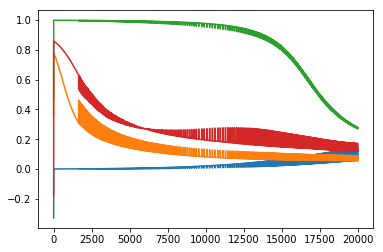

ds


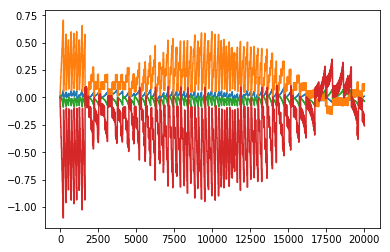

A1


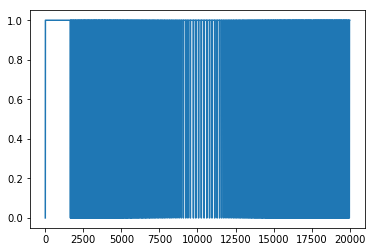

A2


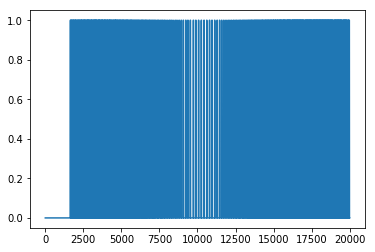

diffs


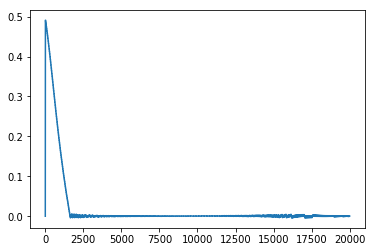

ez1


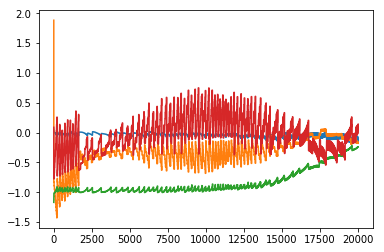

ez2


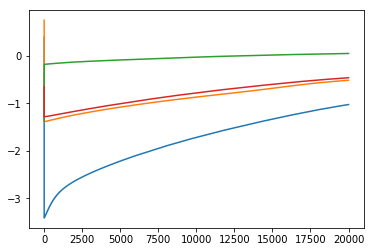

ez3


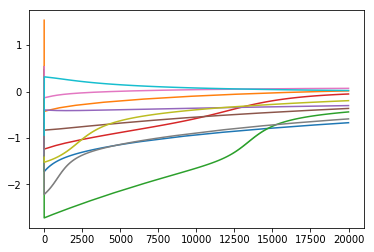

mu1


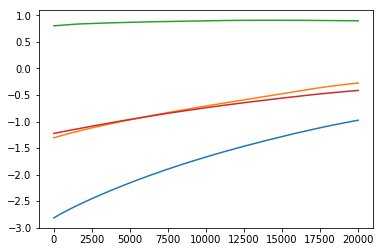

mu2


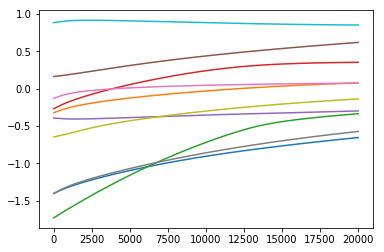

mu3


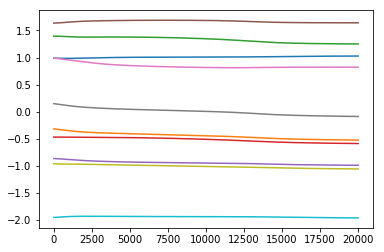

w0


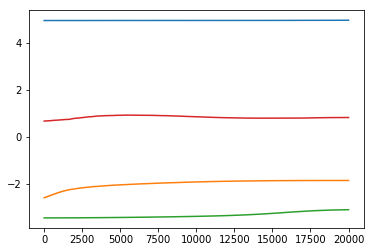

w1


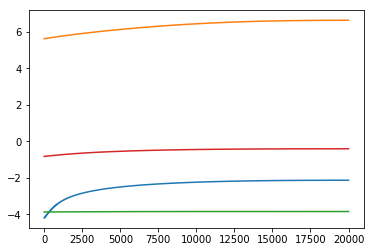

w2


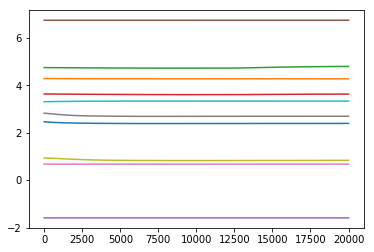

wa1


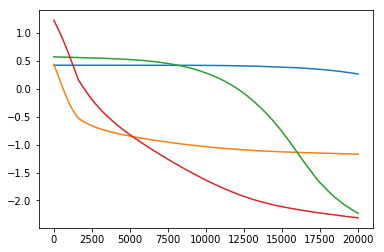

wa2


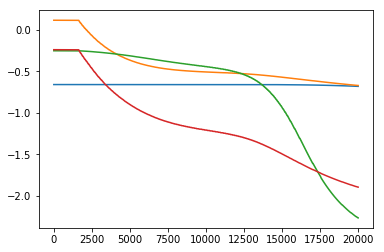

mu1grads


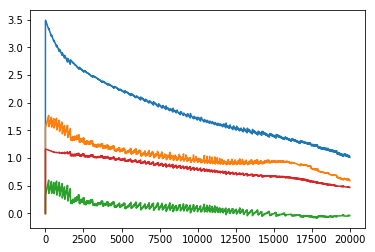

diffs1


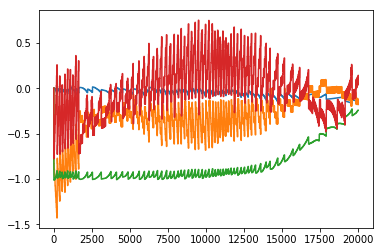

diffs2


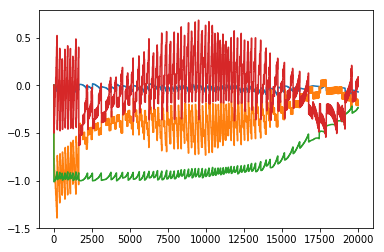

In [156]:
epochs = 1000
inf_num = 20

def sigmoid(x):
    return 1 / (1 + np.exp(-1*x))
    #return x

def sigmoidderiv(x):
    return sigmoid(x) * (1 - sigmoid(x))
    #return sigmoid(x)

def relu(x):
    if x > 0:
        return x
    return 0

def reluderiv(x):
    if x > 0:
        return 1
    return 0


def reshapes(l, val):
    for i, e in enumerate(l):
        print(i)
        l[i] = np.reshape(np.array(e), (len(e), val))
    return l

def reshape_sum_weights(l):
    for i, e in enumerate(l):
        l[i] = np.array(np.sum(e, axis=2))
    return l

def sum_of_squares(l):
    tot = 0
    for e in l:
        tot += np.sum(np.square(e))
    return tot

def euclid(a,b):
    tot  = 0
    for (ax,bx) in zip(a,b):
        tot += (ax-bx)**2
    return np.sqrt(tot)
        

d1 = 4
d2 = 10

phi = [np.reshape(np.array(env.reset()), (4,1))]
mu1 = [np.random.normal(size=[d1,1])]
mu2 = [np.random.normal(size=[d2,1])]
mu3 = [np.random.normal(size=[d2,1])]
prevObs = phi[0]

ez1 = [np.random.normal(size=[4,1])]
ez2 = [np.random.normal(size=[d1,1])]
ez3 = [np.random.normal(size=[d2,1])]


p1 = 0.1
p2 = 0.1
p3 = 0.1

w0 = [np.random.normal(size=[4,d1])]
w1 = [np.random.normal(size=[d1,d2])]
w2 = [np.random.normal(size=[d2,d2])]



print(w0[0].shape)

wa1 = [np.random.normal(size=[4,1])]
wa2 = [np.random.normal(size=[4,1])]

a1 = [0]
a2 = [0]
rewards = []
rewards_per_epoch = []
actions = []
diffs1 = [np.reshape(np.array([0,0,0,0]), (4,1))]
diffs2 = [np.reshape(np.array([0,0,0,0]), (4,1))]

prior = np.reshape(np.array([0,0,0,0]), (4,1))
num_resets = 0
diffs =[0]
preds = [np.random.normal(size=[4,1])]
learning_rate = 0.00005
ds = [prior]
mu1grads = [np.reshape(np.array([0,0,0,0]), (4,1))]
for i in range(1,epochs * inf_num):
        pred = np.dot(w0[i-1], mu1[i-1])
        ohat1 = sigmoid((pred + wa1[i-1]))
        ohat2 = sigmoid(pred + wa2[i-1])
        diffa01 = ohat1 - prior
        diffa11 = ohat2 - prior
        diff = np.sum(np.square(diffa01))- np.sum(np.square(diffa11))
        if diff >=0:
            # a1 is best
            action = 0
            a1.append(1)
            a2.append(0)
        else:
            action = 1
            a1.append(0)
            a2.append(1)
       
        o, r, done, info = env.step(action)
        rewards.append(r)
        env.render()
        o = np.reshape(np.array(o), (4,1)) / 3.
        phi.append(o)
        prevObs = o
        eo1 = o - ohat1
        eo2 = o - ohat2
        diffs.append(diff)
        diffs1.append(eo1)
        diffs2.append(eo2)

        
        if done:
            print(o)
            env.reset()
            prior = np.reshape(np.array([0,0,0,0]), (4,1))
            num_resets +=1
            rewards_per_epoch.append(np.sum(rewards))
            rewards = []
    else:
        #print(phi[i-1])
        phi.append(phi[i-1])
        a1.append(a1[i-1])
        a2.append(a2[i-1])
        diffs.append(diffs[i-1])
        diffs1.append(diffs1[i-1])
        diffs2.append(diffs2[i-1])
        
    p1 = np.dot(w0[i-1], mu1[i-1])
    p2 = np.dot(w1[i-1], mu2[i-1])
    p3 = np.dot(w2[i-1], mu3[i-1])
        
    ez1.append(phi[i] - (sigmoid(p1 + (wa1[i-1] * a1[i]) + (wa2[i-1] * a2[i]))))
    ez2.append(mu1[i-1] - sigmoid(p2))
    ez3.append(mu2[i-1] - sigmoid(p3))
    
    mu1grad = np.dot(w0[i-1].T, sigmoidderiv(p1 + (wa1[i-1] * a1[i]) + (wa2[i-1] * a2[i])) * ez1[i]) - ez2[i]#(sigmoidderiv(p2) * ez2[i])
    mu2grad = np.dot(w1[i-1].T, sigmoidderiv(p2) * ez2[i]) - ez3[i]#(sigmoidderiv(p3) * ez3[i])
    mu3grad = np.dot(w2[i-1].T, sigmoidderiv(p3) * ez3[i]) 
    mu1grads.append(mu1grad)
    
    mu1.append(mu1[i-1] + (learning_rate * mu1grad))
    mu2.append(mu2[i-1] + (learning_rate * mu2grad))
    mu3.append(mu3[i-1] + (learning_rate * mu3grad))
    
    d = prior - o
    ds.append(d)
    pred = np.dot(w0[i-1], mu1[i-1])
    diffa01 = prior - sigmoid(pred + wa1[i-1]
    diffa02 = prior - sigmoid(pred + wa2[i-1])
    diff = diffa01 - diffa02
    wa1.append(wa1[i-1] + (100 * learning_rate * ((sigmoidderiv(p1 + wa1[i-1]) * ez1[i] * a1[i]) + (sigmoidderiv(pred + wa1[i-1]) * d * a1[i]))))
    wa2.append(wa2[i-1] + (100 * learning_rate * ((sigmoidderiv(p1 + wa2[i-1]) * ez1[i] * a2[i]) + (sigmoidderiv(pred + wa2[i-1]) * d * a2[i]))))
    if i % inf_num == 0:
        w0.append(w0[i-1] + (100*learning_rate * np.dot(ez1[i] * sigmoidderiv(p1 + (wa1[i-1] * a1[i]) + (wa2[i-1] * a2[i])) , mu1[i].T))) 
        w1.append(w1[i-1] + (100*learning_rate * np.dot(ez2[i] * sigmoidderiv(p2), mu2[i].T)))
        w2.append(w2[i-1] + (100* learning_rate * np.dot(ez3[i] * sigmoidderiv(p3), mu3[i].T)))
        
    else:
        w0.append(w0[i-1])
        w1.append(w1[i-1])
        w2.append(w2[i-1])
        
        
    preds.append(sigmoid(np.dot(w0[i-1], mu1[i-1]) + (wa1[i-1] * a1[i]) + (wa2[i-1] * a2[i])))
    
    
phi, ez1, ez2, mu1, wa1, wa2, preds,ds,mu1grads, diffs1, diffs2 = reshapes([phi, ez1, ez2, mu1,wa1, wa2, preds,ds, mu1grads, diffs1, diffs2],d1)
ez3, mu2, mu3 = reshapes([ez3,mu2,mu3], d2)
w0, w1, w2 = reshape_sum_weights([w0, w1, w2])

print("NUM RESETS: " + str(num_resets))
print("Average Reward per epoch: " + str(np.mean(rewards_per_epoch)))
n  = range(epochs * inf_num )
print(n)
print(phi.shape)
print("Phi")
plt.plot(n, phi)
plt.show()
print("Pred phi")
plt.plot(n, preds)
plt.show()
print("ds")
plt.plot(n, ds)
plt.show()
print("A1")
plt.plot(n, a1)
plt.show()
print("A2")
plt.plot(n, a2)
plt.show()
print("diffs")
plt.plot(n, diffs)
plt.show()
print("ez1")
plt.plot(n, ez1)
plt.show()
print("ez2")
plt.plot(n, ez2)
plt.show()
print("ez3")
plt.plot(n, ez3)
plt.show()
print("mu1")
plt.plot(n, mu1)
plt.show()
print("mu2")
plt.plot(n, mu2)
plt.show()
print("mu3")
plt.plot(n, mu3)
plt.show()
print("w0")
plt.plot(n, w0)
plt.show()
print("w1")
plt.plot(n, w1)
plt.show()
print("w2")
plt.plot(n, w2)
plt.show()
print("wa1")
plt.plot(n, wa1)
plt.show()
print("wa2")
plt.plot(n, wa2)
plt.show()
print("mu1grads")
plt.plot(n, mu1grads)
plt.show()
print("diffs1")
#
plt.plot(diffs1)
plt.show()
print("diffs2")
plt.plot(diffs2)
plt.show()

In [1]:
epochs = 1000
inf_num = 20

def sigmoid(x):
    return 1 / (1 + np.exp(-1*x))
    #return x

def sigmoidderiv(x):
    return sigmoid(x) * (1 - sigmoid(x))
    #return sigmoid(x)

def relu(x):
    if x > 0:
        return x
    return 0

def reluderiv(x):
    if x > 0:
        return 1
    return 0


def reshapes(l, val):
    for i, e in enumerate(l):
        print(i)
        l[i] = np.reshape(np.array(e), (len(e), val))
    return l

def reshape_sum_weights(l):
    for i, e in enumerate(l):
        l[i] = np.array(np.sum(e, axis=2))
    return l

def sum_of_squares(l):
    tot = 0
    for e in l:
        tot += np.sum(np.square(e))
    return tot

def euclid(a,b):
    tot  = 0
    for (ax,bx) in zip(a,b):
        tot += (ax-bx)**2
    return np.sqrt(tot)
        

d1 = 4
d2 = 4

phi = [np.reshape(np.array(env.reset()), (4,1))]
mu1 = [np.random.normal(scale=0.1,size=[d1,1])]
mu2 = [np.random.normal(scale=0.1,size=[d2,1])]
mu3 = [np.random.normal(scale=0.1,size=[d2,1])]
prevObs = phi[0]

ez1 = [np.random.normal(scale=0.1,size=[4,1])]
ez2 = [np.random.normal(scale=0.1,size=[d1,1])]
ez3 = [np.random.normal(scale=0.1,size=[d2,1])]

ezR = [0]


p1 = 0.1
p2 = 0.1
p3 = 0.1

w0 = [np.random.normal(scale=0.1,size=[4,d1])]
w1 = [np.random.normal(scale=0.1,size=[d1,d2])]
w2 = [np.random.normal(scale=0.1,size=[d2,d2])]
wR = [np.random.normal(scale=0.1,size=[d2,1])]





print(w0[0].shape)

wa1 = [np.random.normal(scale=0.1,size=[4,1])]
wa2 = [np.random.normal(scale=0.1,size=[4,1])]

a1 = [0]
a2 = [0]
rewards = []
rewards_per_epoch = []
actions = []
diffs1 = [np.reshape(np.array([0,0,0,0]), (4,1))]
diffs2 = [np.reshape(np.array([0,0,0,0]), (4,1))]

prior = np.reshape(np.array([0,0,0,0]), (4,1))
num_resets = 0
diffs =[0]
preds = [np.random.normal(size=[4,1])]
learning_rate = 0.00005
ds = [prior]
diffQ = [0]
mu1grads = [np.reshape(np.array([0,0,0,0]), (4,1))]
oldPred = 0
eR = [0]
wrGrads = [np.reshape(np.array([0,0,0,0]), (4,1))]
Qs = [0]
for i in range(1,epochs * inf_num):
    if i % inf_num == 0 or i == 1:
       
        pred = np.dot(w0[i-1], mu1[i-1])
        if i == 1: 
            oldPred = pred
        ohat1 = sigmoid((pred + wa1[i-1]))
        ohat2 = sigmoid(pred + wa2[i-1])
        Qa1 = np.dot(wR[i-1].T, ohat1)
        Qa2 = np.dot(wR[i-1].T, ohat2)
        diffQ.append(Qa1 - Qa2) 
        if Qa1 >= Qa2:
            action = 0
            a1.append(1)
            a2.append(0)
            Q = Qa1
        else:
            action = 1
            a1.append(0)
            a2.append(1)
            Q = Qa2
            
        Qs.append(Q)
       
        o, r, done, info = env.step(action)
        rewards.append(r)
        env.render()
        o = np.reshape(np.array(o), (4,1)) / 3.
        phi.append(o)
        prevObs = o
        eo1 = o - ohat1
        eo2 = o - ohat2
        diffs.append(diff)
        diffs1.append(eo1)
        diffs2.append(eo2)
       
        R = -1 * np.sum(np.abs(o))
        vs = np.dot(wR[i-1].T,o)
        Qstar = np.amax(np.array([vs + wa1[i-1],vs + wa2[i-1]]))
        eR.append((R + (0.9 * Qstar)) - Q)
    

        
        if done:
            #print(o)
            env.reset()
            prior = np.reshape(np.array([0,0,0,0]), (4,1))
            num_resets +=1
            rewards_per_epoch.append(np.sum(rewards))
            rewards = []
    else:
        #print(phi[i-1])
        phi.append(phi[i-1])
        a1.append(a1[i-1])
        a2.append(a2[i-1])
        diffs.append(diffs[i-1])
        diffs1.append(diffs1[i-1])
        diffs2.append(diffs2[i-1])
        eR.append(eR[i-1])
        diffQ.append(diffQ[i-1])
        Qs.append(Qs[i-1])
        
    p1 = np.dot(w0[i-1], mu1[i-1])
    p2 = np.dot(w1[i-1], mu2[i-1])
    p3 = np.dot(w2[i-1], mu3[i-1])
        
    ez1.append(phi[i] - (sigmoid(p1 + (wa1[i-1] * a1[i]) + (wa2[i-1] * a2[i]))))
    ez2.append(mu1[i-1] - sigmoid(p2))
    ez3.append(mu2[i-1] - sigmoid(p3))
    
    mu1grad = np.dot(w0[i-1].T, sigmoidderiv(p1 + (wa1[i-1] * a1[i]) + (wa2[i-1] * a2[i])) * ez1[i]) - ez2[i]#(sigmoidderiv(p2) * ez2[i])
    mu2grad = np.dot(w1[i-1].T, sigmoidderiv(p2) * ez2[i]) - ez3[i]#(sigmoidderiv(p3) * ez3[i])
    mu3grad = np.dot(w2[i-1].T, sigmoidderiv(p3) * ez3[i]) 
    mu1grads.append(mu1grad)
    
    mu1.append(mu1[i-1] + (learning_rate * mu1grad))
    mu2.append(mu2[i-1] + (learning_rate * mu2grad))
    mu3.append(mu3[i-1] + (learning_rate * mu3grad))
    
    d = prior - o
    ds.append(d)
    pred = np.dot(w0[i-1], mu1[i-1])
    diffa01 = prior - sigmoid(pred + wa1[i-1])
    diffa02 = prior - sigmoid(pred + wa2[i-1])
    diff = diffa01 - diffa02
    wa1.append(wa1[i-1] + (100 * learning_rate * ((sigmoidderiv(p1 + wa1[i-1]) * ez1[i] * a1[i]) + (sigmoidderiv(pred + wa1[i-1]) * d * a1[i]))))
    wa2.append(wa2[i-1] + (100 * learning_rate * ((sigmoidderiv(p1 + wa2[i-1]) * ez1[i] * a2[i]) + (sigmoidderiv(pred + wa2[i-1]) * d * a2[i]))))
    if i % inf_num == 0:
        w0.append(w0[i-1] + (100*learning_rate * np.dot(ez1[i] * sigmoidderiv(p1 + (wa1[i-1] * a1[i]) + (wa2[i-1] * a2[i])) , mu1[i].T))) 
        w1.append(w1[i-1] + (100*learning_rate * np.dot(ez2[i] * sigmoidderiv(p2), mu2[i].T)))
        w2.append(w2[i-1] + (100* learning_rate * np.dot(ez3[i] * sigmoidderiv(p3), mu3[i].T)))
      
        newPred = (np.dot(w0[i-1], mu1[i-1]) + (wa1[i-1] * a1[i])) + (wa2[i-1] * a2[i])
        oldPredA = (oldPred + (wa1[i-1] * a1[i]) + (wa2[i-1] * a2[i]))
        wRgrad = eR[i-1] * (newPred - oldPredA)
        #print(newPred)
        #print(oldPredA)
        #print(eR[i-1])
        #print("\n")
        wR.append(wR[i-1] + (100 * learning_rate * wRgrad))
        wrGrads.append(wRgrad)
        oldPred = pred
        
        
    else:
        w0.append(w0[i-1])
        w1.append(w1[i-1])
        w2.append(w2[i-1])
        wR.append(wR[i-1])
        wrGrads.append(wrGrads[i-1])
        
        
    preds.append(sigmoid(np.dot(w0[i-1], mu1[i-1]) + (wa1[i-1] * a1[i]) + (wa2[i-1] * a2[i])))
    
    
phi, ez1, ez2, mu1, wa1, wa2, preds,ds,mu1grads, diffs1, diffs2,wR, wrGrads = reshapes([phi, ez1, ez2, mu1,wa1, wa2, preds,ds, mu1grads, diffs1, diffs2,wR, wrGrads],d1)
ez3, mu2, mu3 = reshapes([ez3,mu2,mu3], d2)
w0, w1, w2 = reshape_sum_weights([w0, w1, w2])

names = ["phi", "pred_phi", "ds", "A1", "A2", "ez1", "ez2", "ez3", "mu1","mu2","mu3","w0","w1","w2","wa1","wa2","mu1grads","diffs1", "diffs2", "eR", "wR", "diffQ", "wrGrads","Qss"]
vals = [phi, preds, ds,a1,a2, ez1,ez2,ez3,mu1,mu2,mu3,w0,w1,w2,wa1,wa2,mu1grads,diffs1, diffs2,eR, wR, diffQ, wrGrads, Qs]

print("NUM RESETS: " + str(num_resets))
print("Average Reward per epoch: " + str(np.mean(rewards_per_epoch)))
n  = range(epochs * inf_num )
print("PLOTTING!")
for (name, val) in zip(names, vals):
    print(name)
    plt.plot(n,val)
    plt.show()
    

NameError: name 'np' is not defined